In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

# Load and preprocess data
df = pd.read_csv('S&P 500.csv')
df = df[['Date','Price']]
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].str.replace(",", "", regex=True).astype(float)
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)
df = df.drop('Date',axis = 1)

#print(df.head)
#df['Returns'] = df['Price'].diff().fillna(0)
#print(df)


#Splitting the data for later evaluation
#train_data = X_train
#test_data = X_test
X_train = df['Price'].loc[:300].values.reshape(-1,1)
X_test = df['Price'].loc[300:].values.reshape(-1,1)

# Normalization:

scaler = MinMaxScaler() #default range = (0,1)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


Now our task is to make prediction for the price of the next day based on the price of the last 'seq_len' days. To do so we have to get a sequence that contains the price of the last 'seq_len' day, the target for that sequence for every possible training data points.

In [3]:
def sequencer(seq_len:int,data:list): # we shall iterate from seq_len to len(data)-1
  train,target = [],[]
  for i in range(seq_len,len(data)-1):
    train.append(data[(i-seq_len):i])
    target.append(data[i])
  return(np.array(train),np.array(target))


In [4]:
X_train,y_train = sequencer(10,X_train_scaled)
X_test,y_test = sequencer(10,X_test_scaled)


In [17]:
model = Sequential([
    SimpleRNN(units=30, return_sequences=False, input_shape=(10, 1)),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# now we check how thats work on the training set first, it shall go pretty wll
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1448
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0554 
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0397 
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0386 
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369 
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0433 
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0337 
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311 
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0322 
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304 
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0340 
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0323 
Epoch 16/20
10/1

MAE = 124.11274609375
MAPE = 2.3386217811223506


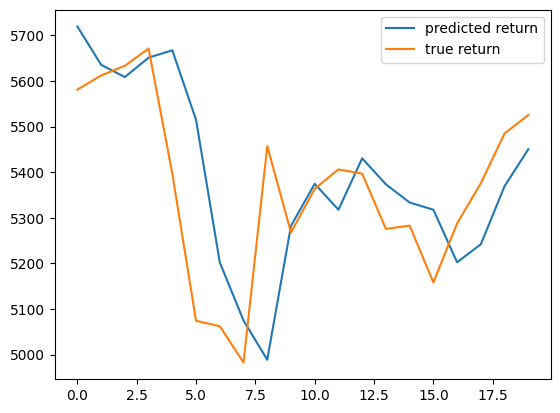

In [16]:
plt.plot(predictions,label='predicted return')
plt.plot(y_test,label = 'true return')
plt.legend()
# now we print some of the evaluation metrics:

print(f'MAE = {1/len(y_test)*np.sum(abs(y_test-predictions))}')
print(f'MAPE = {1/len(y_test)*np.sum(abs((y_test-predictions)/y_test))*100}')